# Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import pydot
import json
import os
import pygraphviz
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Open files

In [3]:
files = os.listdir('parsed_data/')
files.remove('.DS_Store')

In [4]:
files

['Colfer Eoin. Artemis Fowl.json',
 'Colfer Eoin. Artemis Fowl. The Opal Deception.json',
 'Colfer Eoin. Artemis Fowl. The Lost Colony.json',
 'Colfer Eoin. Artemis Fowl: The Eternity Code.json',
 'Colfer Eoin. Artemis Fowl and the Atlantis Complex.json',
 'Colfer Eoin. Artemis Fowl: The Time Paradox.json',
 'Colfer Eoin. Artemis Fowl. The Arctic Incident.json']

In [5]:
# Presents how books are ordered in the series
books_order = {1: 'Artemis Fowl', 2: 'Artemis Fowl and the Arctic Incident',
               3: 'Artemis Fowl and the Eternity Code', 4: 'Artemis Fowl and the Opal Deception',
               5: 'Artemis Fowl and the Lost Colony', 6: 'Artemis Fowl and the Time Paradox',
               7: 'Artemis Fowl and the Atlantis Complex'}

# Convert data into a _networkx_ tree

In [6]:
def get_tree(data):
    G = nx.Graph()
    G.add_node('Text')
    
    sentiment = []
    edgelist = []
    root_to_chapter = []
    for chapter in json_data['text']['chapters']:
        chapt_title = chapter['chapter_title']
        G.add_node(chapt_title)
        G.add_edge(chapt_title, 'Text')
        root_to_chapter.append(('Text', chapt_title))
        par_num = 1
        sentiment.append(chapter['chapter_sentiment'])
        for paragraph in chapter['paragraphs']:
            chapt_par = str(chapter['chapter_number']) +  ' paragraph ' + str(par_num)
            G.add_node(chapt_par)
            G.add_edge(chapt_par, chapt_title)
            sent_num = 1
            for sentence in paragraph['sentences']:
                chapt_par_sent = str(chapter['chapter_number']) +  ' paragraph ' + str(par_num) + str(sent_num)
                G.add_node(chapt_par_sent)
                G.add_edge(chapt_par_sent, chapt_par)
                edgelist.append((chapt_par, chapt_par_sent))
                sent_num += 1
            par_num += 1
    return G, sentiment, root_to_chapter, edgelist

# An example of a simple radial tree graph

Generate a networkx graph.  The process is quite straightforward.  Firstly,  agraph is initialized, and a root node 0 is created.  Then, step by step, the next nodes are adding along with connecting new nodes with their parents through edges.

In [7]:
G = nx.Graph()
G.add_node(0)

count = 5
for i in range(1, 6):
    G.add_node(i)
    G.add_edge(i, 0)
    for j in range(3):
        count += 1
        G.add_node(j)
        G.add_edge(count, i)

Generate a plot. A Graphviz layout named “twopy” is responsponsible for displaying graph as a radial tree.  Here edge width and thickness are equal to one, and also nodes are visible.

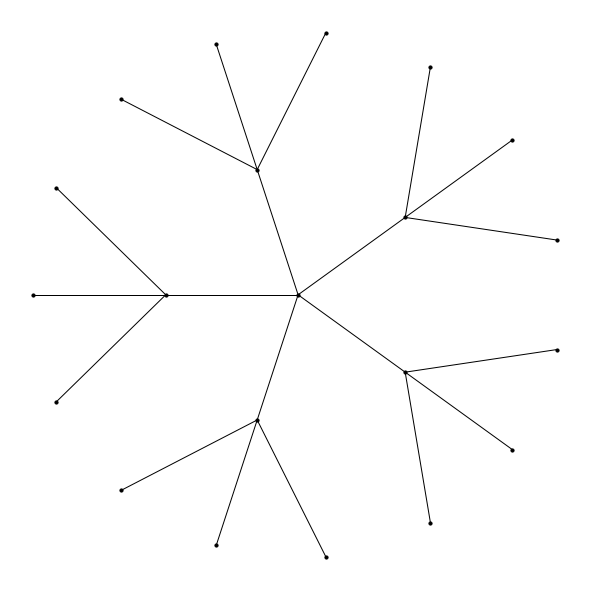

In [8]:
plt.figure(figsize=(8, 8))

pos = graphviz_layout(G, prog="twopi", root=0)
nx.draw(G, pos,
        with_labels=False,
        alpha=1,
        edge_width=1,
        node_size=10,
        node_color='black')

plt.axis('off')
plt.show()

# Generate radial tree graphs

An examlple of a graph before parameters were tuned

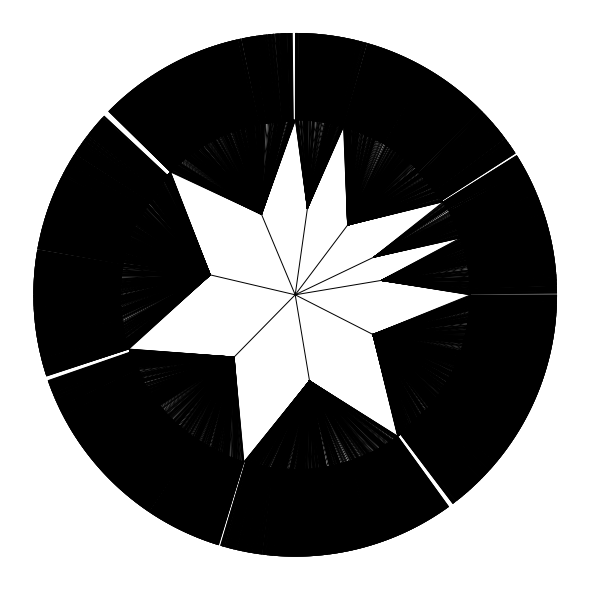

In [9]:
with open('parsed_data/' + files[0]) as f:
    json_data = json.loads(f.read())
G, sentiment, root_to_chapter, edgelist = get_tree(json_data)

plt.figure(figsize=(8, 8))
pos = nx.nx_pydot.pydot_layout(G, prog='twopi', root='Text')
nx.draw(G, pos,
        with_labels=False,
        alpha=1,
        node_size=0)

plt.axis('off')
plt.show()

An example of a graph after parameters are tuned

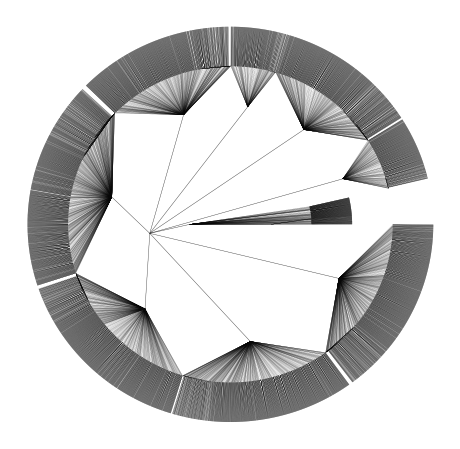

In [10]:
plt.figure(figsize=(8, 8))

pos = graphviz_layout(G, prog="twopi", root=0)

nx.draw_networkx_nodes(G, pos,node_size=0, alpha=0)
nx.draw_networkx_edges(G, pos, width=0.1, alpha=1)
nx.draw_networkx_edges(G, pos, edgelist=root_to_chapter,
                       width=0.5, alpha=0.5)
nx.draw_networkx_edges(G, pos,
                       edgelist=edgelist,
                       width=0.3, alpha=0.2)
plt.axis('off')
plt.show()

A function to create and save radial tree graphs with tuned parameters

In [11]:
def generate_and_save_graph(data, G, root_to_chapter, edgelist, path):
    fig = plt.figure(figsize=(10, 10))

    pos = graphviz_layout(G, prog="twopi", root=0)

    nx.draw_networkx_nodes(G, pos,node_size=0, alpha=0)
    nx.draw_networkx_edges(G, pos, width=0.1, alpha=1)
    nx.draw_networkx_edges(G, pos, edgelist=root_to_chapter,
                           width=0.5, alpha=0.5)

    nx.draw_networkx_edges(G, pos,
                           edgelist=edgelist,
                           width=0.3, alpha=0.2)
    plt.axis('off')
    plt.savefig(path + '/' + data['title'] + '.png')
    plt.close(fig)

# Generate gradient

In [12]:
def create_gradient(color1, color2, n):
    color1 = np.array(mpl.colors.to_rgb(color1))
    color2 = np.array(mpl.colors.to_rgb(color2))
    return mpl.colors.to_hex((1 - n) * color1 + n * color2)

In [13]:
def map_colors(sentiment, pos, neg, neu):
    colors = []
    for i in sentiment:
        if i < -0.1:
            colors.append(neg)
        elif i > 0.1:
            colors.append(pos)
        else:
            colors.append(neu)
    return colors[::-1]

In [22]:
def generate_and_save_gradient(sentiment, path, negative_col, neutral_col, positive_col):
    colors = map_colors(sentiment, pos=positive_col, neg=negative_col, neu=neutral_col)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    n=500
    coord = 1
    for i in range(len(colors)):
        if i == len(colors) - 1:
            break
        if i == 0 or i + 1 == len(colors) - 1:
            m = int(1.5 * int(1.5 * n/len(colors)))
        else:
            m = int(1.5 * int(n/len(colors)))
        c1 = colors[i]
        c2 = colors[i+1]
        for x in range(coord, coord+m):
            ax.axhline(x, color=create_gradient(c1,c2,(x-coord)/m), linewidth=7)
        coord += m + 7

    plt.axis('off')
    #plt.show()
    plt.savefig(path + '/' + json_data['title'] + '_gradient.png')

An example of a generated gradient for the first book in a series.

In [15]:
colors = {'neg': '#687A4A', 'neu': '#669453', 'pos': '#60A869'}

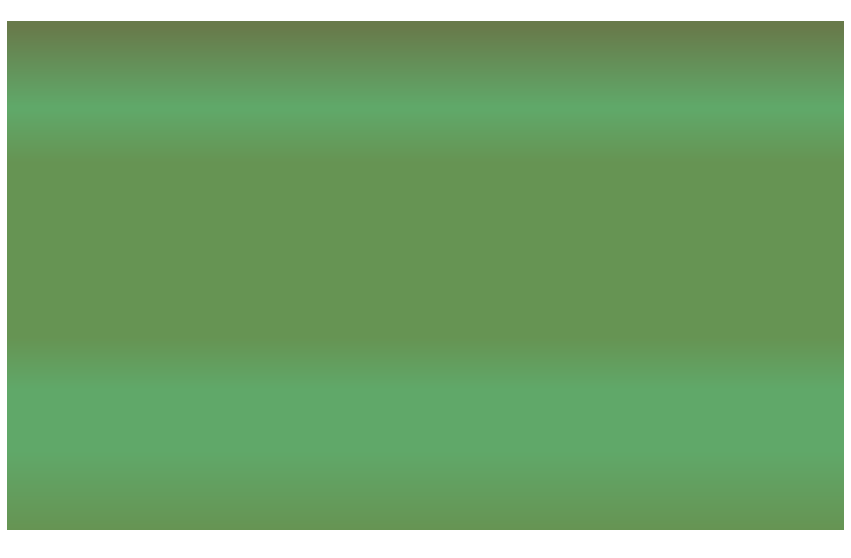

In [18]:
generate_and_save_gradient(sentiment, path='/', negative_col=colors['neg'],
                           neutral_col=colors['neu'], positive_col=colors['pos'])

# Color palettes for the books

<img src="images/colors.jpg" width="200">

In [24]:
# Color pallettes for all seven books
colors1 = {'neg': '#687A4A', 'neu': '#669453', 'pos': '#60A869'}
colors2 = {'neg': '#4A794F', 'neu': '#539571', 'pos': '#5FA89F'}
colors3 = {'neg': '#4A7971', 'neu': '#538795', 'pos': '#5F79A9'}
colors4 = {'neg': '#4B5C7A', 'neu': '#545595', 'pos': '#7B5FA9'}
colors5 = {'neg': '#5B4979', 'neu': '#825495', 'pos': '#A75F9E'}
colors6 = {'neg': '#794A74', 'neu': '#955476', 'pos': '#A85F68'}
colors7 = {'neg': '#794A50', 'neu': '#956153', 'pos': '#A88D60'}

color_palettes = [
    [1, colors1],
    [2, colors2],
    [3, colors3],
    [4, colors4],
    [5, colors5],
    [6, colors6],
    [7, colors7]
]

# Save graphs and backgrounds

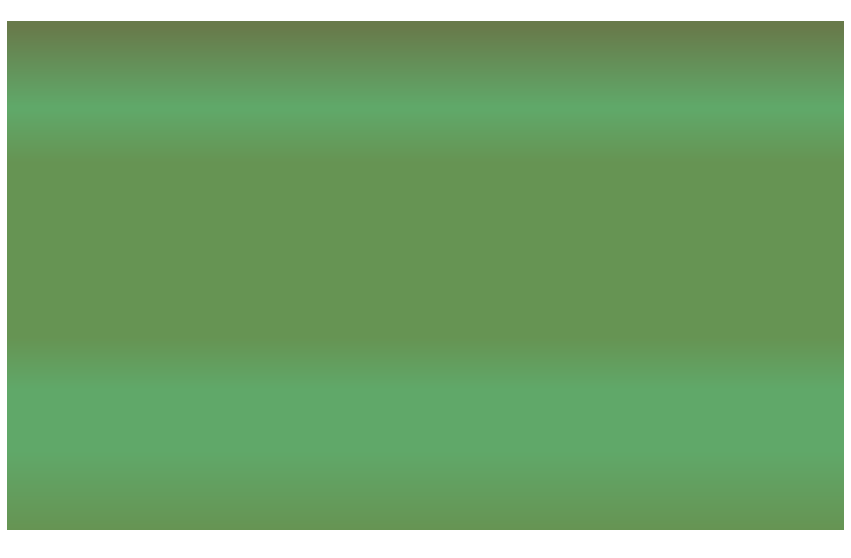

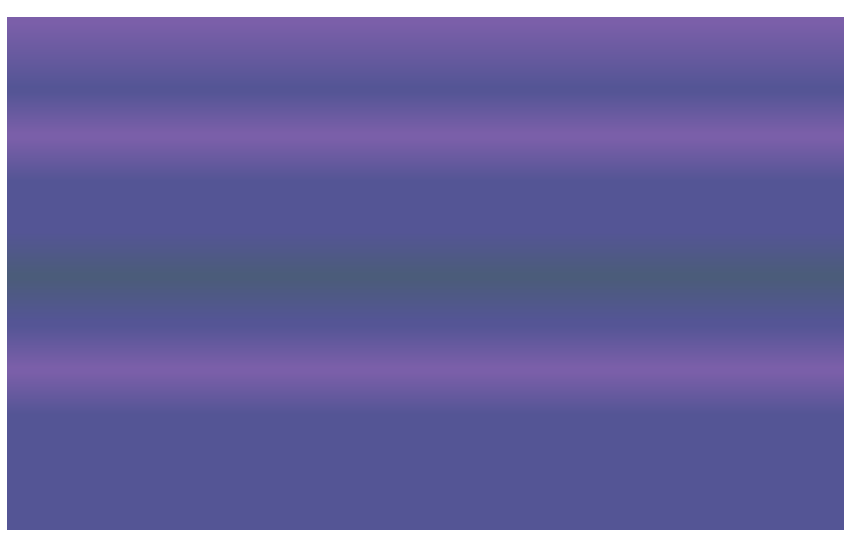

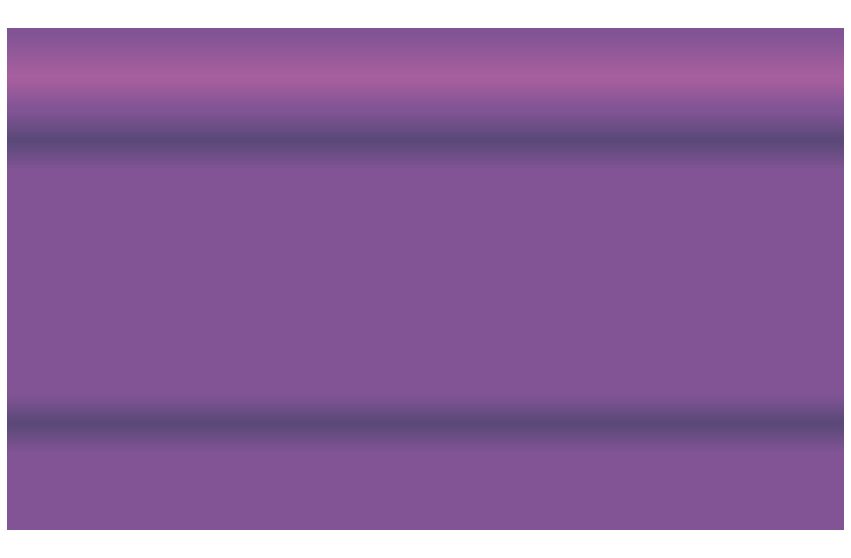

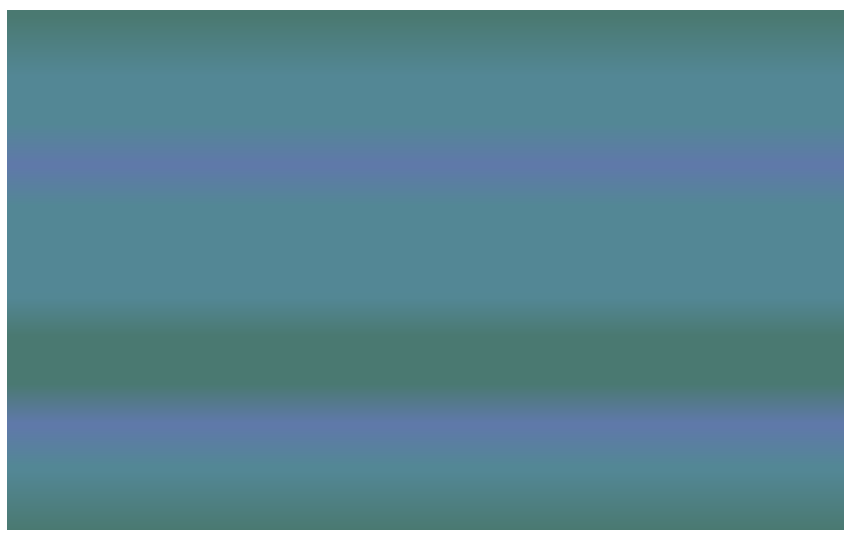

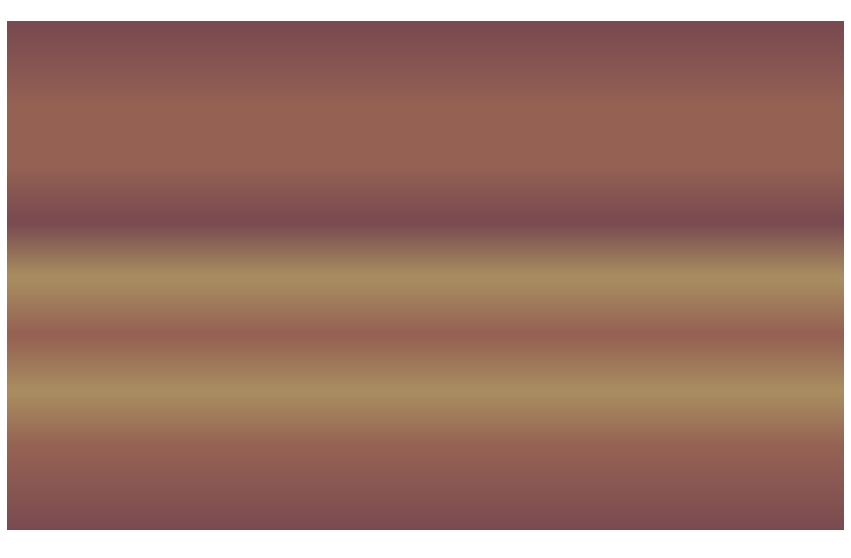

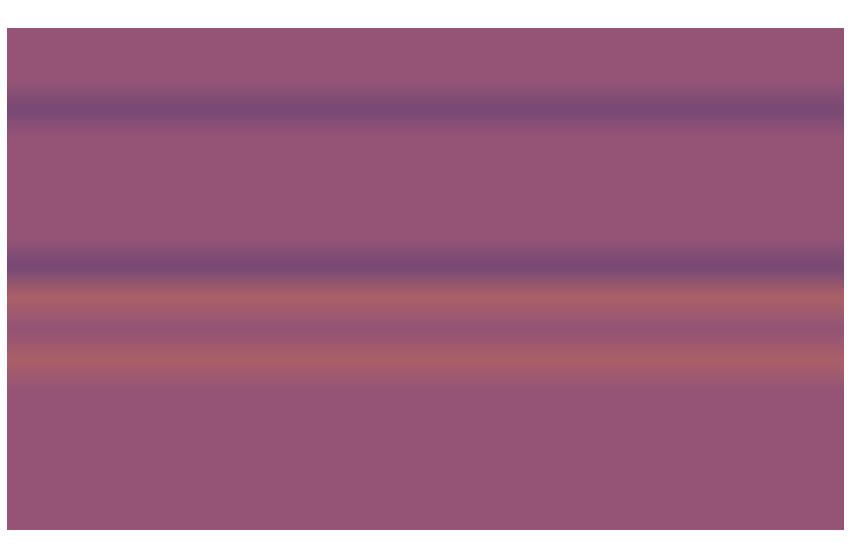

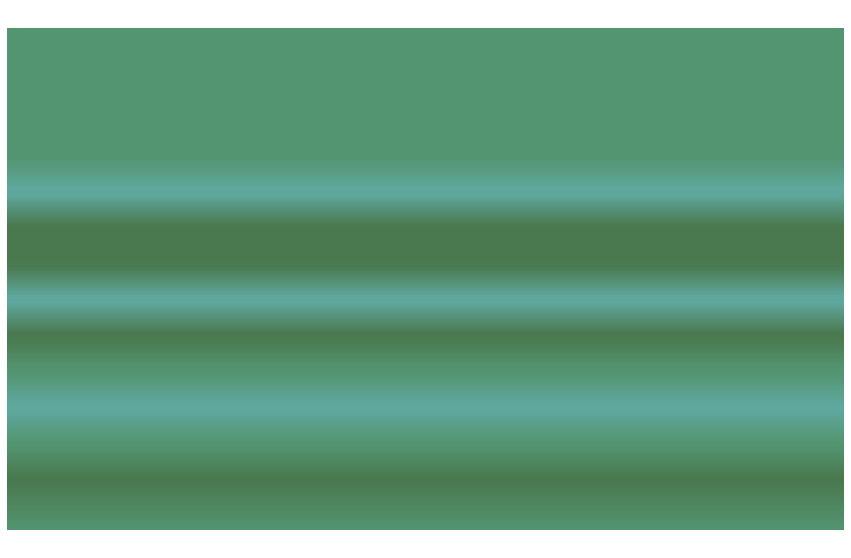

In [30]:
for file in files:
    with open('parsed_data/' + file) as f:
        json_data = json.loads(f.read())
    book_name = json_data['title'].replace('Colfer Eoin. ', '').replace('.', ' and').replace(':', ' and').replace('The', 'the')
    book_number = [key for key,value in books_order.items() if value == book_name][0]
    color_palette = [element[1] for element in color_palettes if element[0] == book_number][0]
    path = 'radial_tree/' + str(book_number) + ' ' + book_name
    if not os.path.exists(path):
        os.mkdir(path)
    
    G, sentiment, root_to_chapter, edgelist = get_tree(json_data)
    generate_and_save_graph(json_data, G, root_to_chapter, edgelist, path)
    generate_and_save_gradient(sentiment, path, negative_col=color_palette['neg'],
                               neutral_col=color_palette['neu'], positive_col=color_palette['pos'])